In [2]:
%matplotlib notebook
import os
import numpy as np
from glob import glob
import pickle
import ipywidgets as widgets
from IPython.display import display
from functools import partial
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)

regex_nrn = re.compile(r'NEURON\s*\{(\s*[\w+,]\s*)*\s\}?', re.MULTILINE)
regex_state = re.compile(r'STATE\s*\{(\s*([\w+,:])\s*)*\s*\}?', re.MULTILINE)
#regex_breakpoint = re.compile(r'(?<=BREAKPOINT)\s*\{(?P<st_txt>[^}]+)(?=\})')
regex_breakpoint = re.compile(r'BREAKPOINT\s*\{(?P<st_txt>[^}]+)\}')

In [3]:
#load data dictionary from pkl file
iontype = "Ca"
sub_channel = '/media/icg-channels/icg-channels-' + iontype
f = open(sub_channel+".pkl","rb")
data_dict = pickle.load(f)

<IPython.core.display.Javascript object>


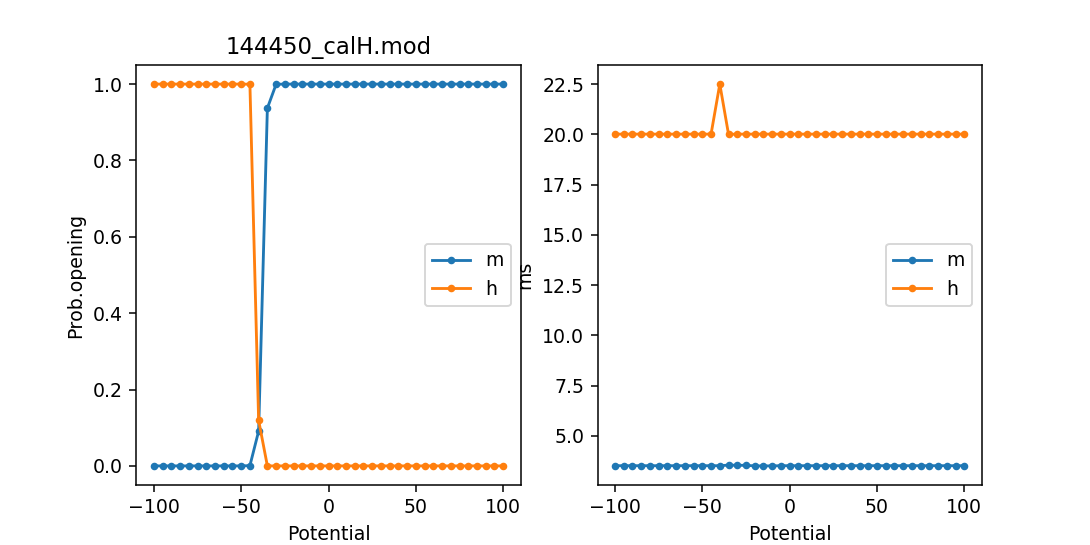

In [4]:
class Counter:
    def __init__(self, initial=0):
        self.value = initial

    def increment(self, amount=1):
        self.value += amount
        return self.value

    def decrement(self, amount=1):
        self.value -= amount
        return self.value
    
    def set_value(self, amount):
        self.value = amount
        return self.value
    
    def __iter__(self, sentinal=False):
        return iter(self.increment, sentinal)

def fetch_data(filename):
    with open(filename, 'r') as handle:
        data = np.loadtxt(handle)
        x = data[:, 0]
        y = data[:, 1]
    return x, y
    

def refresh_figure(fig, foldername, axs):
    folderpath = os.path.join(sub_channel, foldername)
    for ax in axs:
        ax.clear()
    fig.canvas.draw_idle()
    mod_files = glob(folderpath + '/*.mod')
    for mod_file in mod_files:
        if mod_file.find('sm') == -1:
            orig_file = mod_file
    with open(orig_file, 'r') as handle:  
        all_mod = handle.read()
        txt_area_mod.value = all_mod
        nrn_txt = regex_nrn.search(all_mod).group()
        state_reg = regex_state.search(all_mod)
        try:
            bp_txt = regex_breakpoint.search(all_mod).group()
        except AttributeError:
            bp_txt = ''
            print('No breakpoint related string found in regex')
        if not state_reg:
            state_txt = ''
        else:
            state_txt = state_reg.group()
        txt_area_test.value = str(nrn_txt + '\n' + state_txt + '\n' + bp_txt)
    
    if data_dict[foldername]['RATES']: 
        gates = data_dict[foldername]['STATES']
        for gate in gates:
            rate_file = glob(folderpath + '/RATES/*.' + gate + '.inf.37.dat')[0]
            x, y = fetch_data(rate_file)
            axs[0].plot(x, y,label=gate, marker='.')
            tau_file = glob(folderpath + '/RATES/*.' + gate + '.tau.37.dat')[0]
            x, y = fetch_data(tau_file)
            axs[1].plot(x, y,label=gate, marker='.')
        axs[0].set_xlabel('Potential')
        axs[0].set_ylabel('Prob.opening')
        axs[0].set_title(foldername)
        axs[1].set_xlabel('Potential')
        axs[1].set_ylabel('ms')
        axs[0].legend()
        axs[1].legend()
    else:
        axs[0].text(0, 0.5, 'NO RATES')
        axs[1].text(0, 10, 'NO RATES')
        pass

counter = Counter()
all_channels = list(data_dict.keys())

fig = plt.figure(figsize=(8, 4))
rates_ax = fig.add_subplot(121)
tau_ax = fig.add_subplot(122)

next_button = widgets.Button(description='Next Channel',
                             disabled=False, button_style='')
prev_button = widgets.Button(description='Prev Channel',
                             disabled=False, button_style='')
refresh_button = widgets.Button(description='Refresh',
                                disabled=False, button_style='')
txt_box = widgets.Text(value=str(all_channels[0]), description='Channel Name:',
                       disabled=False)
txt_area_mod = widgets.Textarea(value='Hello World',
                                disabled=False, layout=widgets.Layout(width='500px', height='700px'))
txt_area_test = widgets.Textarea(value='Hello World',
                                 disabled=False, layout=widgets.Layout(width='300px', height='400px'))

refresh_figure(fig, all_channels[0], [rates_ax, tau_ax])


def on_nxt_btn_clicked(counter, b):
    txt_box.value = all_channels[counter.increment()]
    on_refresh_btn_clicked(counter, b)
    
def on_prev_btn_clicked(counter, b):
    txt_box.value = all_channels[counter.decrement()]
    on_refresh_btn_clicked(counter, b)
    
def on_refresh_btn_clicked(counter, b):
    refresh_figure(fig, txt_box.value, [rates_ax, tau_ax])
    fig.canvas.draw()
    
next_button.on_click(partial(on_nxt_btn_clicked, counter))
prev_button.on_click(partial(on_prev_btn_clicked, counter))
refresh_button.on_click(partial(on_refresh_btn_clicked, counter))
items = [prev_button, txt_box, next_button, refresh_button]
plt.show()

In [5]:
widgets.HBox(items)

A Jupyter Widget

No breakpoint related string found in regex
No breakpoint related string found in regex


In [7]:
widgets.HBox([txt_area_mod, txt_area_test])

A Jupyter Widget